In [1104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import geopy.distance as distance
import geopandas as gpd
from shapely.geometry import Point

import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

from data_collection import get_bounding_box, get_date_range, normalize_landsat, normalize_sentinel

In [1105]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

sat_image_catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

In [1106]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [1107]:
# read .csv files
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
submission_format = pd.read_csv(DATA_DIR / "submission_format.csv", index_col=0)
metadata = pd.read_csv(DATA_DIR / "metadata.csv")

In [1108]:
df = metadata.merge(train_labels, on='uid', how='inner')
df.sort_values('density', ascending=False).head(20)

,uid,latitude,longitude,date,split,region,severity,density
7843,lvtt,39.210670,-96.972980,2015-10-05,train,midwest,5,8.046675e+08
13853,vbvq,38.388890,-97.093060,2013-06-10,train,midwest,5,1.959300e+08
16198,yqgb,39.211550,-97.005590,2014-09-22,train,midwest,5,9.127360e+07
12797,tlfq,39.210670,-96.972980,2015-07-13,train,midwest,5,7.660800e+07
4287,gnlr,43.329370,-108.156190,2021-08-17,train,west,5,7.181390e+07
8235,mmwy,39.210670,-96.972980,2015-10-26,train,midwest,5,6.016500e+07
3486,fhyp,39.407630,-99.446670,2018-06-18,train,midwest,5,5.969250e+07
3036,epww,39.399200,-99.424810,2018-08-13,train,midwest,5,5.953500e+07
9506,omai,42.217010,-109.370990,2021-08-31,train,west,5,4.356760e+07
8360,mrrk,44.359408,-104.833233,2019-09-09,train,west,5,4.260262e+07


In [1109]:
#example_row = metadata[metadata.uid == "garm"].iloc[0]
#example_row = metadata[metadata.uid == "fund"].iloc[0]
###example_row = metadata[metadata.uid == "aafl"].iloc[0] # high severity (class 4)
#example_row = metadata[metadata.uid == "gnlr"].iloc[0] # high severity (class 5)
#example_row = metadata[metadata.uid == "omai"].iloc[0] # high severity (class 5)
#example_row = metadata[metadata.uid == "uwka"].iloc[0] # high severity (class 5)
example_row = metadata[metadata.uid == "phbj"].iloc[0] # high severity (class 5)
example_row

uid                phbj
latitude       42.21665
longitude    -109.37081
date         2021-07-26
split             train
Name: 13885, dtype: object

In [1110]:
sent_bands_descr = {
    #'AOT': 'Aerosol optical thickness (AOT)',
    #'B01': 'Coastal aerosol - 60m',
    'B04': 'Red - 10m',
    'B03': 'Green - 10m',
    'B02': 'Blue - 10m',
    #'B05': 'Vegetation red edge 1 - 20m',
    #'B06': 'Vegetation red edge 2 - 20m',
    #'B07': 'Vegetation red edge 3 - 20m',
    'B08': 'NIR - 10m',
    #'B09': 'Water vapor - 60m',
    #'B11': 'Short Wave IR (1.6) - 20m',
    #'B12': 'Short Wave IR (2.2) - 20m',
    #'B8A': 'Vegetation red edge 4 - 20m',
    #'SCL': 'Scene classfication map (SCL)',
    #'WVP': 'Water vapour (WVP)',
}
sent_bands = list(sent_bands_descr.keys())

landsat_bands_descr = {
    #'qa': 'Surface Temperature Quality Assessment Band',
    #'ang': 'Angle Coefficients File',
    'red': 'Red Band',
    'green': 'Green Band',
    'blue': 'Blue Band',
    #'drad': 'Downwelled Radiance Band',
    #'emis': 'Emissivity Band',
    #'emsd': 'Emissivity Standard Deviation Band',
    #'trad': 'Thermal Radiance Band',
    #'urad': 'Upwelled Radiance Band',
    #'atran': 'Atmospheric Transmittance Band',
    #'cdist': 'Cloud Distance Band',
    'nir08': 'Near Infrared Band 0.8',
    #'lwir11': 'Surface Temperature Band',
    #'swir16': 'Short-wave Infrared Band 1.6',
    #'swir22': 'Short-wave Infrared Band 2.2',
    #'coastal': 'Coastal/Aerosol Band',
    #'mtl.txt': 'Product Metadata File (txt)',
    #'mtl.xml': 'Product Metadata File (xml)',
    #'mtl.json': 'Product Metadata File (json)',
    #'qa_pixel': 'Pixel Quality Assessment Band',
    #'qa_radsat': 'Radiometric Saturation and Terrain Occlusion Quality Assessment Band',
    #'qa_aerosol': 'Aerosol Quality Assessment Band',
    #'tilejson': 'TileJSON with default rendering',
    #'rendered_preview': 'Rendered preview',
}
landsat_bands = list(landsat_bands_descr.keys())

band_names = ['red', 'green', 'blue', 'nir']

In [1111]:
# get a bounding box around our coordinate point
image_size = 128
meter_buffer = ((10 * image_size) / 2) - 5
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=meter_buffer)
bbox

[-109.3785005250809, 42.21093326743339, -109.36311947491912, 42.22236672684872]

In [1112]:
# get our date range to search, and format correctly for query
date_range = get_date_range(example_row.date, time_buffer_days=15)
date_range

'2021-07-11T/2021-07-26T'

In [1113]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search_results = sat_image_catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search_results.get_all_items()]
len(items)

11

In [1114]:
search_results.get_all_items()

ID: S2A_MSIL2A_20210726T180921_R084_T12TXM_20210727T051914
"Bounding Box: [-109.80266, 41.440428735281785, -108.44978, 42.44624086265282]"
Datetime: 2021-07-26 18:09:21.024000+00:00
datetime: 2021-07-26T18:09:21.024000Z
platform: Sentinel-2A
proj:epsg: 32612
instruments: ['msi']
s2:mgrs_tile: 12TXM
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20210727T051915_A031827_T12TXM_N03.00
eo:cloud_cover: 0.060114


In [1115]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "cloud_cov": item.properties['eo:cloud_cover'],
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)
item_details = item_details[item_details["contains_sample_point"]]

num_sentinel = len(item_details[item_details.platform.str.contains("Sentinel")])
num_landsat  = len(item_details[item_details.platform.str.contains("landsat")])
print(f"Number of Sentinel items found: {num_sentinel}")
print(f"Number of Landsat items found: {num_landsat}")

image_layers = dict.fromkeys(band_names, np.array(0))

if num_sentinel > 0:
    # If sentinel is available, it is first choice.
    # Select closest image by date.
    # TODO: Refine selection by using the less cloudy image when there's more than one image for the date
    item = (
        item_details[item_details.platform.str.contains("Sentinel")]
        .sort_values(by="datetime", ascending=False)
        .iloc[0]
        ).item_obj

    # collect layers in dict
    for band, name in zip(sent_bands, band_names):
        image = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
            minx=bbox[0],
            miny=bbox[1],
            maxx=bbox[2],
            maxy=bbox[3],
            crs="EPSG:4326",
        ).to_numpy()
        # normalize pixel values into range 0.0 to 1.0
        normalized = normalize_sentinel(image[0])
        if (normalized.shape[0] != image_size) or (normalized.shape[1] != image_size):
            print(f'Shape {name}: {normalized.shape} -->RESIZED!!!')
            image_layers[name] = cv2.resize(normalized, ( image_size, image_size), interpolation = cv2.INTER_AREA)
        else:
            image_layers[name] = normalized
    print('Sentinel')

elif num_landsat > 0:
    # If only Landsat is available we have to use it instead
    item = (
        item_details[item_details.platform.str.contains("landsat")]
        .sort_values(by="datetime", ascending=False)
        .iloc[0]
        ).item_obj

    # collect layers in dict
    for band, name in zip(landsat_bands, band_names):
        image = odc.stac.stac_load([pc.sign(item)], bands=[band], bbox=bbox).isel(time=0)

        # scale pixel values into practical range
        normalized = normalize_landsat(image[[band]].to_array().to_numpy()[0])
        # upscale landsat images to same pixel size as sentinel
        image_layers[name] = cv2.resize(normalized, ( image_size, image_size), interpolation = cv2.INTER_AREA)
    print('Landsat')

else:
    for band, name in zip(landsat_bands, band_names):
        image_layers[name] = np.zeros([image_size, image_size])
    print("No Image was found!")

#print(f"Shape {np.array(list(image_layers.items())).shape}")
print(f"Shape red: {image_layers['red'].shape}")
print(f"Shape green: {image_layers['green'].shape}")
print(f"Shape blue: {image_layers['blue'].shape}")
print(f"Shape nir: {image_layers['nir'].shape}")


image_layers['nir']

Number of Sentinel items found: 7
Number of Landsat items found: 4
Shape red: (131, 130) -->RESIZED!!!
Shape green: (131, 130) -->RESIZED!!!
Shape blue: (131, 130) -->RESIZED!!!
Shape nir: (131, 130) -->RESIZED!!!
Sentinel
Shape red: (128, 128)
Shape green: (128, 128)
Shape blue: (128, 128)
Shape nir: (128, 128)


array([[0.45680788, 0.44863147, 0.43970898, ..., 0.34715134, 0.35284072,
        0.3389038 ],
       [0.45377558, 0.44499508, 0.43536618, ..., 0.35178223, 0.35370535,
        0.34676972],
       [0.4524523 , 0.45030057, 0.43963942, ..., 0.35456288, 0.34942925,
        0.34870353],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

In [1116]:
# # What assets are available?
# for asset_key, asset in item.assets.items():
#     print(f"{asset_key:<25} - {asset.title}")

## Testing with different bands

* [Sentinel 2 Bands and Combinations](https://gisgeography.com/sentinel-2-bands-combinations/)
* [Sentinel 2 RGB Band values (for scaling)](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/definitions)

In [1117]:
bands_iter = iter(sent_bands)
bands_iter = iter(landsat_bands)

In [1118]:
# band = next(bands_iter)

# visual_img_array = rioxarray.open_rasterio(pc.sign(item.assets['visual'].href)).rio.clip_box(
#         minx=bbox[0],
#         miny=bbox[1],
#         maxx=bbox[2],
#         maxy=bbox[3],
#         crs="EPSG:4326",
#     ).to_numpy()
# new_img_array = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
#         minx=bbox[0],
#         miny=bbox[1],
#         maxx=bbox[2],
#         maxy=bbox[3],
#         crs="EPSG:4326",
#     ).to_numpy()

# print(visual_img_array.shape)
# print(new_img_array.shape)

# plt.figure(figsize=(14,6))
# plt.subplot(121)
# plt.imshow(np.transpose(visual_img_array, axes=[1, 2, 0]))
# plt.subplot(122)
# plt.imshow(np.transpose(new_img_array, axes=[1, 2, 0]), cmap='gray')
# plt.title(band)

In [1119]:
# # create numpy array for each layer and collect them in dict
# image_layers = dict.fromkeys(bands, np.array(0))
# for band in bands:
#     image_layers[band] = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
#             minx=minx,
#             miny=miny,
#             maxx=maxx,
#             maxy=maxy,
#             crs="EPSG:4326",
#         ).to_numpy()


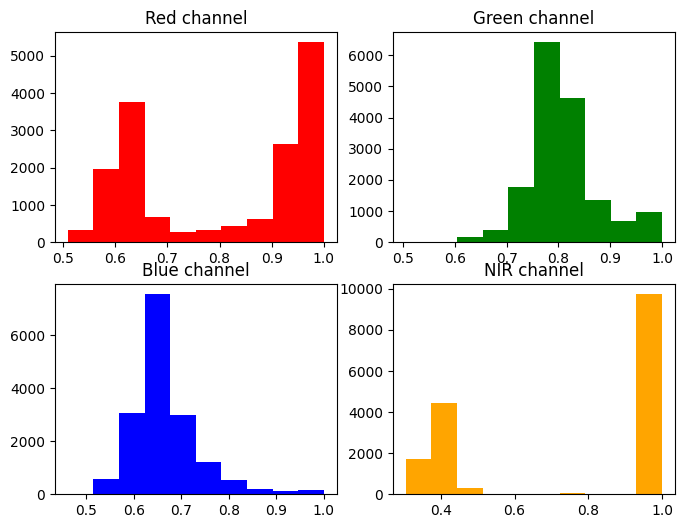

In [1120]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.hist(image_layers['red'].flatten(), color='r');
plt.title('Red channel')
plt.subplot(222)
plt.hist(image_layers['green'].flatten(), color='g');
plt.title('Green channel')
plt.subplot(223)
plt.hist(image_layers['blue'].flatten(), color='b');
plt.title('Blue channel')
plt.subplot(224)
plt.hist(image_layers['nir'].flatten(), color='orange');
plt.title('NIR channel');

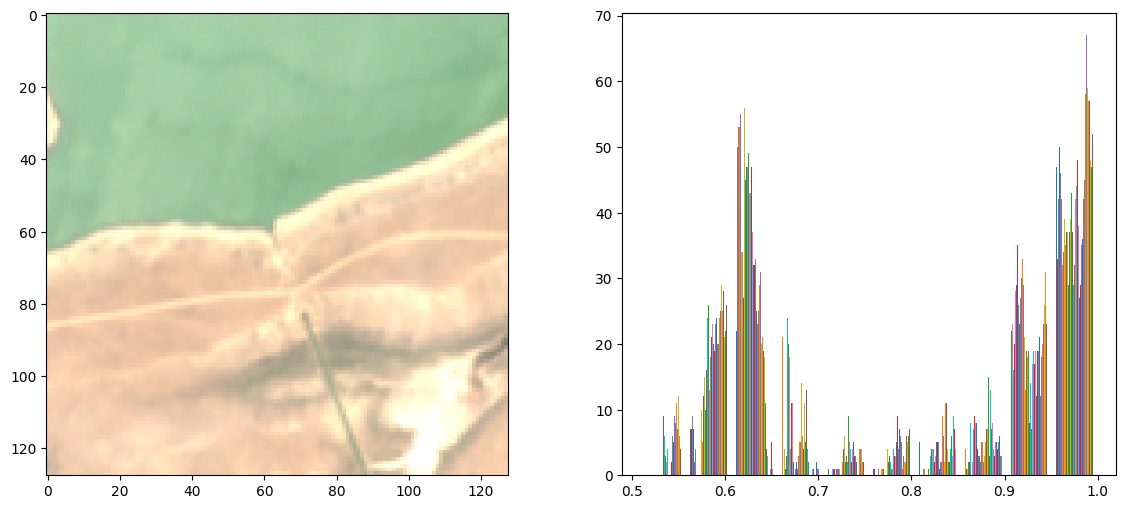

In [1121]:
# RGB image from individual channels
rgb_image = np.array(
        [image_layers['red'],
         image_layers['green'],
         image_layers['blue']]
        )

# show normalized image (range shifted to approximately 0-255, no hard limit though)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((rgb_image), axes=[1, 2, 0]));
plt.subplot(122)
plt.hist(rgb_image[0]);

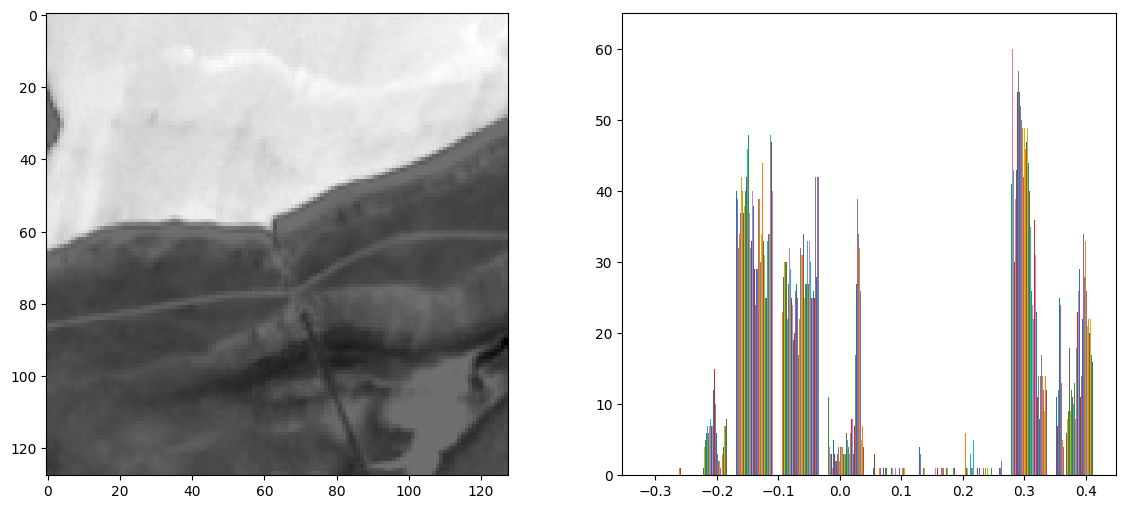

In [1122]:
# NDWI - Normalized Difference Water Index
# Sentinel-2 NDWI = (green - NIR) / (green + NIR)
# source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
# another source: https://en.wikipedia.org/wiki/Normalized_difference_water_index
ndwi_image = np.array([
                (image_layers['green'] - image_layers['nir']) / (image_layers['green'] + image_layers['nir'])
                ]) 

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((ndwi_image), axes=[1, 2, 0]), cmap='gray');
plt.subplot(122)
plt.hist(ndwi_image[0]);

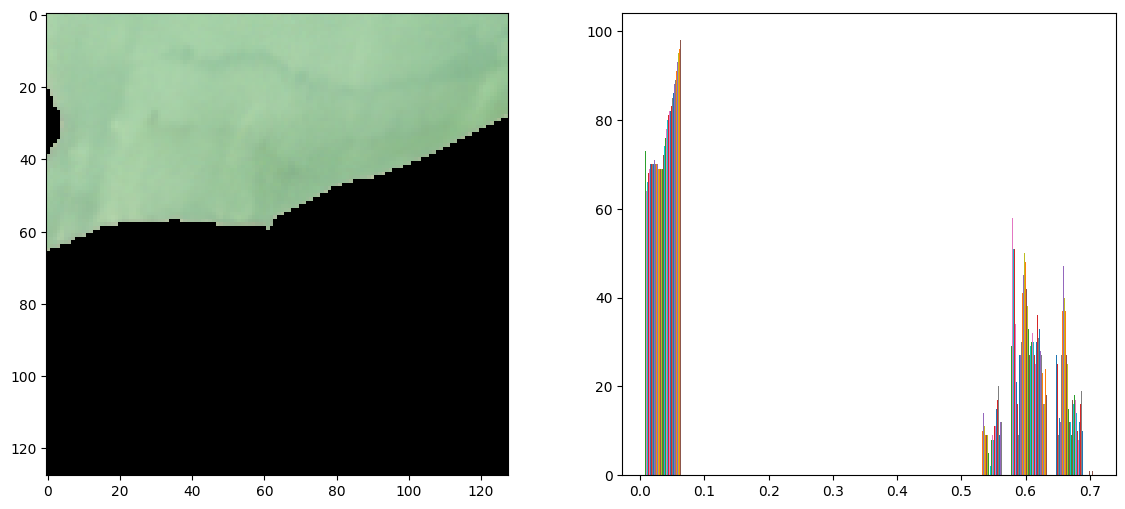

In [1123]:
# create mask based on NDWI values
ndwi_mask = (ndwi_image[0] > 0.12)

# apply mask so that only water pixels are left
masked_image = np.array(
        [image_layers['red'  ] * ndwi_mask,
         image_layers['green'] * ndwi_mask,
         image_layers['blue' ] * ndwi_mask]
        )

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((masked_image), axes=[1, 2, 0]), cmap='gray');
plt.subplot(122)
plt.hist((masked_image)[0]);

In [1124]:
# what about landsat? 
# landsat NDWI possible? -> yes, done
# landsat scaling -> done

# TODO: save 8 layers into file (/data/sat-image-8-layers)



# other ideas:
# HSV transform?


In [1125]:
# Create complete sentinel image with 8 layers
# Layers are: Red, Green, Blue, NIR, Red masked, Green masked, Blue masked, NIR masked
# Masked layers contain only pixels that show water
full_image = np.array([
    image_layers['red'  ],
    image_layers['green'],
    image_layers['blue' ],
    image_layers['nir'  ],
    image_layers['red'  ] * ndwi_mask,
    image_layers['green'] * ndwi_mask,
    image_layers['blue' ] * ndwi_mask,
    image_layers['nir'  ] * ndwi_mask,
    ])

In [1126]:
full_image.shape

(8, 128, 128)

In [1127]:
full_image.min(), full_image.max()

(0.0, 1.0)

In [1128]:
64*64*8*4 *metadata.shape[0] / (1024*1024)

2946.25

In [1129]:
# see the whole image
#img = Image(url=item.assets["rendered_preview"].href, width=500)

#Image(url=item.assets["rendered_preview"].href, width=500)

In [1130]:
# def crop_sentinel_image(item, bounding_box):
#     """
#     Given a STAC item from Sentinel-2 and a bounding box tuple in the format
#     (minx, miny, maxx, maxy), return a cropped portion of the item's visual
#     imagery in the bounding box.

#     Returns the image as a numpy array with dimensions (color band, height, width)
#     """
#     (minx, miny, maxx, maxy) = bounding_box

#     image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
#         minx=minx,
#         miny=miny,
#         maxx=maxx,
#         maxy=maxy,
#         crs="EPSG:4326",
#     )

#     return image.to_numpy()

In [1131]:
# get a smaller geographic bounding box
#minx, miny, maxx, maxy = get_bounding_box(
#    example_row.latitude, example_row.longitude, meter_buffer=500
#)

# get the zoomed in image array
#bbox = (minx, miny, maxx, maxy)
#zoomed_img_array = crop_sentinel_image(item, bbox)

#zoomed_img_array[0]

In [1132]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
#plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [1133]:
#zoomed_img_array.shape

### Landsat

In [1134]:
# landsat_item = (
#     item_details[item_details.platform.str.contains("landsat")]
#     .sample(n=1, random_state=3)
#     .iloc[0]
# )
# landsat_item

In [1135]:
# def crop_landsat_image(item, bounding_box):
#     """
#     Given a STAC item from Landsat and a bounding box tuple in the format
#     (minx, miny, maxx, maxy), return a cropped portion of the item's visual
#     imagery in the bounding box.

#     Returns the image as a numpy array with dimensions (color band, height, width)
#     """
#     (minx, miny, maxx, maxy) = bounding_box

#     image = odc.stac.stac_load(
#         [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
#     ).isel(time=0)
#     image_array = image[["red", "green", "blue"]].to_array().to_numpy()

#     # normalize to 0 - 255 values
#     image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

#     return image_array

In [1136]:
#item = landsat_item.item_obj

# # we'll use the same cropped area as above
# landsat_image_array = crop_landsat_image(item, bbox)
# landsat_image_array[0]

In [1137]:
# plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

In [1138]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

<xarray.DataArray (y: 131, x: 130)>
array([[1354., 1356., 1348., ..., 1182., 1176., 1178.],
       [1368., 1338., 1318., ..., 1184., 1184., 1188.],
       [1356., 1336., 1316., ..., 1186., 1178., 1178.],
       ...,
       [1586., 1664., 1676., ..., 2020., 2024., 2030.],
       [1630., 1666., 1644., ..., 1982., 1980., 2022.],
       [1704., 1670., 1702., ..., 2002., 2016., 2022.]], dtype=float32)
Coordinates:
  * y            (y) float64 4.676e+06 4.676e+06 ... 4.674e+06 4.674e+06
  * x            (x) float64 6.338e+05 6.338e+05 ... 6.351e+05 6.351e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2021-07-26T18:09:21.024000
    variable     <U3 'red'

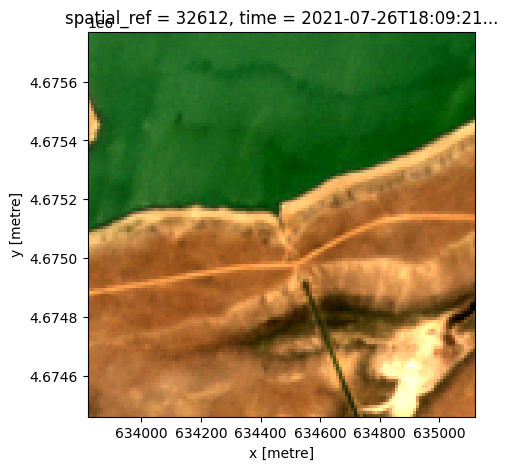

In [1139]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

### same process for all the data

REMOVED